All the needed libraries

In [12]:
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
import wikipediaapi
import nltk
import csv
from dateutil.relativedelta import relativedelta
from IPython.display import display
from csv import writer
from wordcloud import WordCloud


A small component will be displayed to choose the interval to run the API. 

In [4]:
startDatePicker = widgets.DatePicker(
    description="Start date", disabled=False, continuous_update=True
)
endDatePicker = widgets.DatePicker(
    description="Stop date", disabled=False, continuous_update=True
)
numberOfEntries = widgets.IntSlider(
    value=10,
    min=0,
    max=1000,
    step=10,
    description="Num entries",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format="d",
)
TwoByTwoLayout(
    top_left=startDatePicker,
    bottom_left=endDatePicker,
    bottom_right=numberOfEntries,
    align_items="center",
)


TwoByTwoLayout(children=(DatePicker(value=None, description='Start date', layout=Layout(grid_area='top-left'),…

Prepare the data and input for the API callout

In [22]:
ignoredArticles = ["Main_Page", "Special:Search", "Wikipedia", "1234"]
ignoredCategories = [
    "article",
    "outdated",
    "language",
    "Wikipedia",
    "Article",
    "dates",
    "Pages",
    "pages",
    "description",
    "Wikidata",
    "footnote",
]

In [23]:
# create header in csv file
header_list = ["article", "views", "date", "summary", "categories"]

# delete content from existing file is exists any
with open('wikipedia_trending.csv', 'w') as file:
    pass
    dw = csv.DictWriter(file, delimiter=',',  fieldnames=header_list) 
    dw.writeheader() 


Get the date values from the date picker component

In [24]:
startDate = startDatePicker.value
endDate = endDatePicker.value
dateList = []
while startDate <= endDate:
    dateList.append(startDate.strftime("%Y/%m/%d"))
    startDate += relativedelta(days=1)

print(dateList)


['2024/11/01', '2024/11/02', '2024/11/03', '2024/11/04', '2024/11/05', '2024/11/06', '2024/11/07', '2024/11/08', '2024/11/09', '2024/11/10', '2024/11/11', '2024/11/12', '2024/11/13', '2024/11/14', '2024/11/15', '2024/11/16']


Make the callout for each date in the interval

In [25]:

headers = {"User-Agent": "WikiGeeks IBD - Project"}
for date in dateList:
    base_url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/top/en.wikipedia/all-access/"
    # append the current date in the list
    url = base_url + str(date)

    # callout
    response = requests.get(url, headers=headers).json()
    print(response)
    try:

        data = response["items"][0]["articles"]
    except:
        print("Try a different date")
        continue
    print(
        "Currently pulling data for " + date)


    filteredData = data[: (numberOfEntries.value)]


    wiki_api = wikipediaapi.Wikipedia("WikiGeeks", "en")
    trendingData = []
    for article in filteredData:
        # print("start ",  article)
        
        article["date"] = date
        if any(substring in article["article"] for substring in ignoredArticles):
            continue

        # get the article
        page = wiki_api.page(article["article"])

        # get the summary
        article["summary"] = page.summary

        # get the category
        categories = []
        for key in page.categories.keys():
            key = key.replace("Category:", "")
            if not any(substring in key for substring in ignoredCategories):
                categories.append(key)
        article["categories"] = categories
        print("final",  article)
        del article["rank"]
        values = [i for i in article.values()]
        print("values ", values)
       
        with open('wikipedia_trending.csv', 'a', encoding='utf-8') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(values)
            f_object.close()
   
    
    
    
    

{'items': [{'project': 'en.wikipedia', 'access': 'all-access', 'year': '2024', 'month': '11', 'day': '01', 'articles': [{'article': 'Main_Page', 'views': 4276181, 'rank': 1}, {'article': 'Special:Search', 'views': 2519116, 'rank': 2}, {'article': 'Wikipedia:Featured_pictures', 'views': 652154, 'rank': 3}, {'article': 'Diwali', 'views': 238721, 'rank': 4}, {'article': 'Singham_Again', 'views': 225644, 'rank': 5}, {'article': 'Bhool_Bhulaiyaa_3', 'views': 213525, 'rank': 6}, {'article': '2024_United_States_presidential_election', 'views': 212089, 'rank': 7}, {'article': 'Rúben_Amorim', 'views': 192556, 'rank': 8}, {'article': 'Amaran_(2024_film)', 'views': 153824, 'rank': 9}, {'article': 'Halloween', 'views': 153289, 'rank': 10}, {'article': 'Mukund_Varadarajan', 'views': 152049, 'rank': 11}, {'article': 'Day_of_the_Dead', 'views': 135977, 'rank': 12}, {'article': 'Deaths_in_2024', 'views': 134713, 'rank': 13}, {'article': "All_Saints'_Day", 'views': 129211, 'rank': 14}, {'article': 'Rod

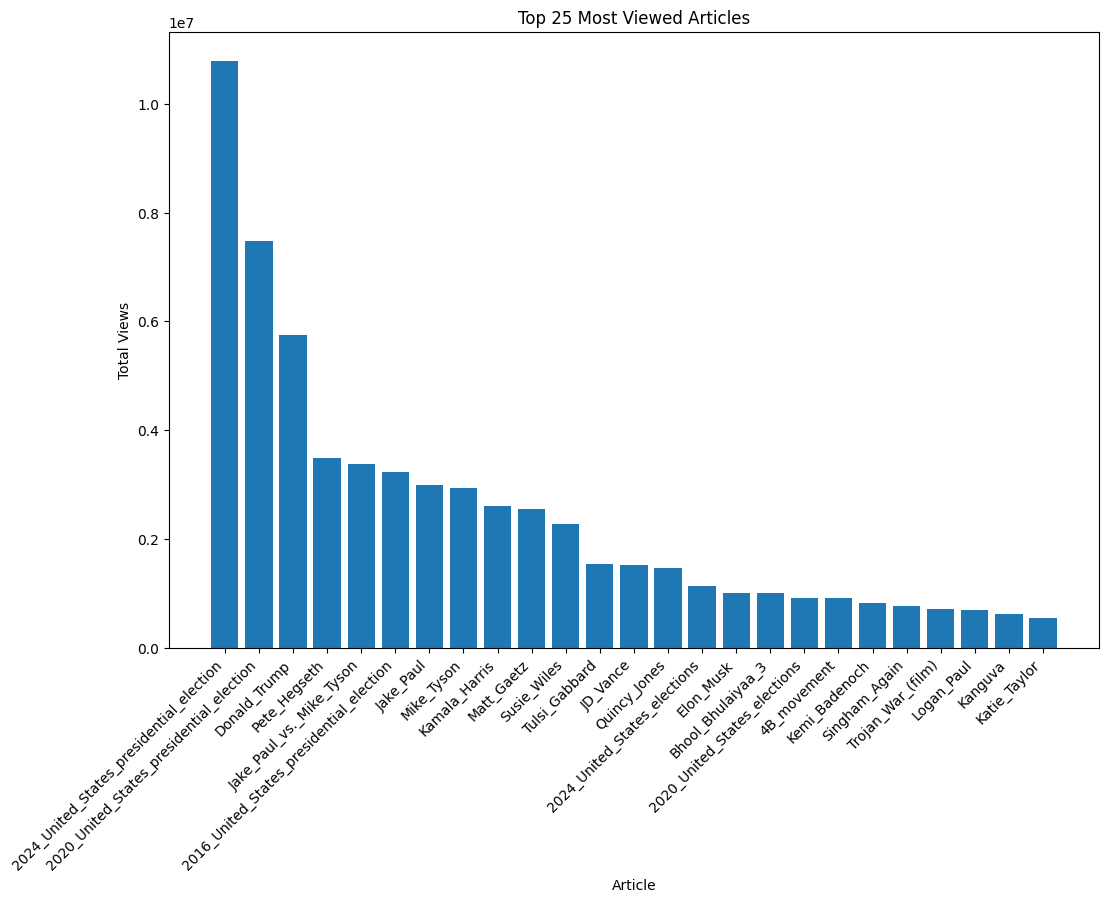

In [26]:
data = pd.read_csv('wikipedia_trending.csv')
data["views"] = data.groupby(["date", "article"])[
    "views"
].transform("sum")
data = data.drop_duplicates(subset=["date", "article"])
total_views_per_article = (
    data.groupby("article")["views"].sum().reset_index()
)
top_25_articles = total_views_per_article.nlargest(25, "views")

plt.figure(figsize=(12, 8))
plt.bar(top_25_articles["article"], top_25_articles["views"])
plt.title("Top 25 Most Viewed Articles")
plt.xlabel("Article")
plt.ylabel("Total Views")
plt.xticks(rotation=45, ha="right")
plt.show()

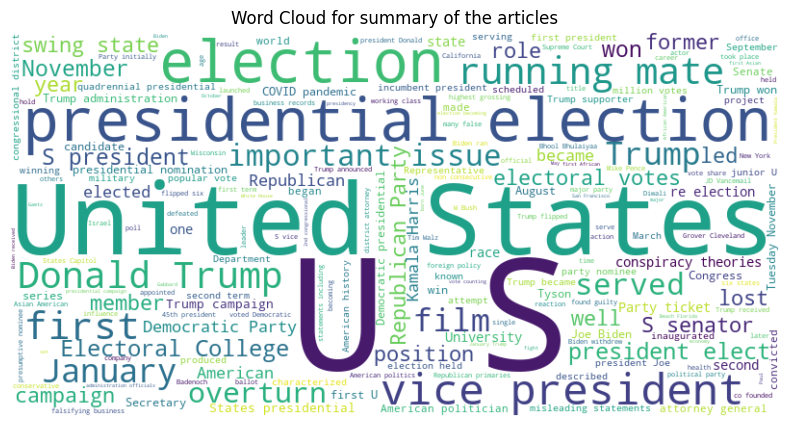

In [27]:
df = pd.read_csv('wikipedia_trending.csv')
data = ' '.join(df["summary"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for summary of the articles')
plt.show()

date
2024-11-01    7
2024-11-02    7
2024-11-03    7
2024-11-04    7
2024-11-05    7
2024-11-06    8
2024-11-07    7
2024-11-08    7
2024-11-09    7
2024-11-10    7
2024-11-11    7
2024-11-12    7
2024-11-13    7
2024-11-14    7
2024-11-15    7
2024-11-16    7
dtype: int64


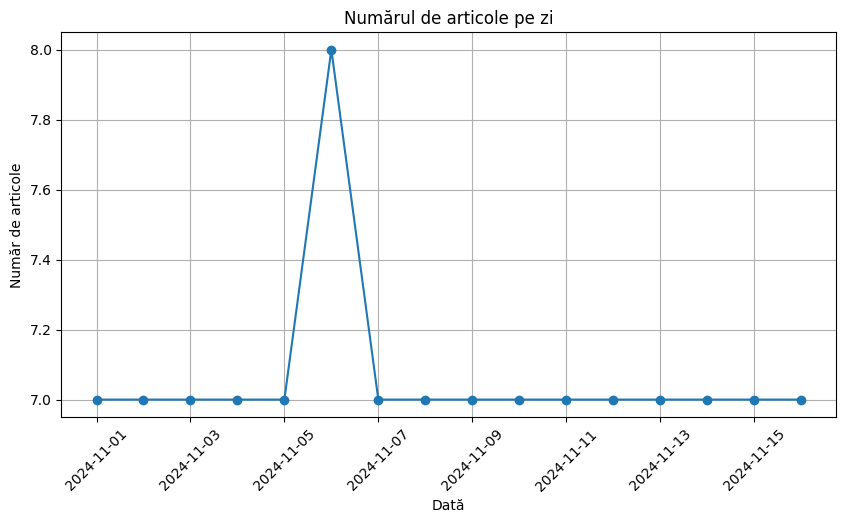

In [28]:
df['date'] = pd.to_datetime(df['date'])

# Gruparea articolelor după data publicării
date_counts = df.groupby(df['date'].dt.date).size()
print(date_counts)
# Plotarea graficului
plt.figure(figsize=(10, 5))
date_counts.plot(kind='line', marker='o')
plt.title('Numărul de articole pe zi')
plt.xlabel('Dată')
plt.ylabel('Număr de articole')
plt.xticks(rotation=45)
plt.grid()
plt.show()